# Advanced Lane Lines

### Imports, Tools, Configuration

In [10]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

%matplotlib qt

# Configuration
SRC_TF = np.float32([ [262.0, 680.0], [1042.0, 680.0], [701.0, 460.0], [580.0, 460.0] ])
DST_TF = np.float32([ [262.0, 720.0], [1042.0, 720.0], [1042.0, 0.0], [262.0, 0.0] ])

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

HISTORY_SIZE = 50

ksize=5

np.set_printoptions(precision=6, suppress=True)

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.reset()
        
    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.best_fit_amnt = 0
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # avg number of points in a fit
        self.average_fit_points = 0.0
        # amount of fit points
        self.amnt_fit_points = []
    
    def addToAverageFitPoints(self, fit_points):
        self.amnt_fit_points.append(float(len(fit_points)))
        
        if len(self.amnt_fit_points) > HISTORY_SIZE:
            del self.amnt_fit_points[0]
            
        self.average_fit_points = sum(self.amnt_fit_points) / float(len(self.amnt_fit_points))
        
    
    def addToAverageBestFit(self, fit, img_shape):
        #self.current_fit.append(fit)
        
        if len(self.recent_xfitted) > HISTORY_SIZE:
            del self.recent_xfitted[0]
        
        #sum_fit = np.zeros_like(fit)
        #for prev_fit in self.current_fit:
         #   sum_fit += prev_fit
        
        #self.best_fit = sum_fit / len(self.current_fit)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
        plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        
        self.recent_xfitted.append(plotx)
        
        complete_y = []
        complete_x = []
        for prev_xfitted in self.recent_xfitted:
            complete_y.extend(ploty)
            complete_x.extend(prev_xfitted)
            
        self.best_fit = np.polyfit(complete_y, complete_x, 2)
        
        
    def toStrings(self):
        return ["Best fit: " + str(self.best_fit), 
                "Detected? " + str(self.detected), 
                "History length: " + str(len(self.recent_xfitted)),
                "Avg Fit Points: " + str(self.average_fit_points)]
        
        
class ImageDisplay():
    def __init__(self, image, label, cmap_str):
        self.image = image
        self.label = label
        self.cmap_str = cmap_str

def wAvg(val1, w1, val2, w2):
    return (val1 * w1 + val2 * w2) / 2.0

def calibrate(nx, ny):
    
    objpoints = []
    imgpoints = []
    
    images = glob.glob('camera_cal/calibration*.jpg')
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        objp = np.zeros((nx*ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True: # meaning that we found chessboard corners
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
            
    cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def thresh(gray, thresh=(0, 255)):
    binary_output = np.zeros_like(gray)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(gray >= thresh[0]) & (gray <= thresh[1])] = 1

    # Return the result
    return binary_output

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    if thresh is not None:
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    return gradmag

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def perspective_transform(img):
    M = cv2.getPerspectiveTransform(SRC_TF, DST_TF)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

def inverse_perspective_transform(img):
    Minv = cv2.getPerspectiveTransform(DST_TF, SRC_TF)
    warped = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]))
    return warped

def gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

def HLS(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def YUV(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return yuv

def H(img):
    hls = HLS(img)
    return hls[:,:,0]

def L(img):
    hls = HLS(img)
    return hls[:,:,1]

def S(img):
    hls = HLS(img)
    return hls[:,:,2]

def Y(img):
    yuv = YUV(img)
    return yuv[:,:,0]

def U(img):
    yuv = YUV(img)
    return yuv[:,:,1]

def V(img):
    yuv = YUV(img)
    return yuv[:,:,2]


def get_histogram(binary_warped, ratio=2.0):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2.0):,:], axis=0)
    return histogram

def sliding_window(binary_warped, left_line, right_line, histogram=None):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    if histogram is None:
        histogram = get_histogram(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_line.addToAverageFitPoints(left_lane_inds)
    right_line.addToAverageFitPoints(right_lane_inds)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    out_img = draw_polygon_with_margin_around_polynomial(out_img, left_fit, 20)
    out_img = draw_polygon_with_margin_around_polynomial(out_img, right_fit, 20)
    
    #if (not left_line.detected):
    left_line.detected = True
    right_line.detected = True

    # average best fit
    left_line.addToAverageBestFit(left_fit, out_img.shape)
    right_line.addToAverageBestFit(right_fit, out_img.shape)
    
    texts = []
    texts.extend(left_line.toStrings())
    texts.extend(right_line.toStrings())
    texts.append("Current Fit Points: L " + str(len(left_lane_inds)) + ",   R " + str(len(right_lane_inds)))
    
    out_img = addText(out_img, texts)
    
    return out_img, left_line, right_line

def draw_polygon_with_margin_around_polynomial(out_img, polynomial, margin, color=(0, 255, 0)):
    window_img = np.zeros_like(out_img)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    plotx = polynomial[0]*ploty**2 + polynomial[1]*ploty + polynomial[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    poly_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
    poly_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin, ploty])))])
    poly_pts = np.hstack((poly_window1, poly_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([poly_pts]), color)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

def draw_polygon_between_polynomials(out_img, left_fit, right_fit):
    window_img = np.zeros_like(out_img)
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(window_img, np.int_([pts]), (0, 255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

def draw_lane_undistorted(undistd, left_fit, right_fit):
    
    # Create an image to draw the lines on
    #lane_zeros = np.zeros_like(undistd).astype(np.uint8)
    #lane_color = np.dstack((lane_zeros, lane_zeros, lane_zeros))
    lane_color = np.zeros_like(undistd)
    
    # draw the lane in top-down view, on the blank image
    lane_color = draw_polygon_between_polynomials(lane_color, left_fit, right_fit)
    
    # warp the lane back into the viewpoint of the car camera
    lane_color_warped = inverse_perspective_transform(lane_color)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistd, 1, lane_color_warped, 0.3, 0)
    
    return result

def detect_from_previous(binary_warped, left_line, right_line):
    
    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # average best fit
    left_line.addToAverageBestFit(left_fit, out_img.shape)
    right_line.addToAverageBestFit(right_fit, out_img.shape)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    result = draw_polygon_with_margin_around_polynomial(out_img, left_fit, margin)
    result = draw_polygon_with_margin_around_polynomial(result, right_fit, margin)
    result = draw_polygon_with_margin_around_polynomial(result, left_line.best_fit, margin, color=(0, 0, 255))
    result = draw_polygon_with_margin_around_polynomial(result, right_line.best_fit, margin, color=(0, 0, 255))
    
    texts = []
    texts.append("Current Fit Points: L " + str(len(left_lane_inds)) + ",   R " + str(len(right_lane_inds)))
    
    out_img = addText(out_img, texts)
    
    #result = draw_polygon_between_polynomials(result, left_fit, right_fit)
    
    return result, left_line, right_line

def measure_curvature(polynomial):
    # measure curvature in pixel space
    y_eval = np.max(binary_warped.shape[0])
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print("curve in pixel space", left_curverad, right_curverad)

    # measure curvature in real world
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print("curve in real world", left_curverad, 'm', right_curverad, 'm')

def undist(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

def process_image_find_cspace(image):
    
    #image_o = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test_images/test_challenge_1.jpg", image_o)
    
    undistd = undist(image)
    persp = perspective_transform(undistd)
    
    return concatenate_4_images(undistd, H(undistd), L(undistd), S(undistd))

def process_image_video1(image):
    undistd = undist(image)
    persp = perspective_transform(undistd)
    gradx = abs_sobel_thresh(L(persp), orient='x', sobel_kernel=ksize, thresh=(10, 100)) # was 10,100
    
    global left_line, right_line
    
    # better not to have sliding window all the time ;-)
    
    result_sl, left_line, right_line = sliding_window(gradx, left_line, right_line)
    if (left_line.detected and right_line.detected):
        result, left_line, right_line = detect_from_previous(gradx, left_line, right_line)
        
    result_warped = draw_lane_undistorted(undistd, left_line.best_fit, right_line.best_fit)
        
    return concatenate_4_images(image, gradx, result_sl, result_warped)

def process_image_video2(image):
    try:
        #image_o = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #cv2.imwrite("test_images/test_challenge_1.jpg", image_o)

        #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        
        
        undistd = undist(image)
        persp = perspective_transform(undistd)
        gradx = abs_sobel_thresh(L(persp), orient='x', sobel_kernel=ksize, thresh=(30, 100)) # was 10,100

        left_lane_line = np.zeros_like(gradx)
        thresholded_L = thresh(L(persp), thresh=(130, 255))
        thresholded_S = thresh(S(persp), thresh=(15, 255))
        left_lane_line[(thresholded_L == 1) & (thresholded_S == 1)] = 1

        right_lane_line = thresh(L(persp), thresh=(180, 255))
        right_lane_line_strict = np.zeros_like(gradx)
        right_lane_line_strict[(right_lane_line == 1) & (gradx == 1)] = 1
        


        both_lane_lines = np.zeros_like(gradx)
        both_lane_lines[(left_lane_line == 1) | (right_lane_line_strict == 1)] = 1

        #histogram = get_histogram(combined2)

        global left_line, right_line

        
        # NOTE: histogram ratio was 1.4
        histogram = get_histogram(both_lane_lines, ratio=1.4)
        
        result_sl, left_line, right_line = sliding_window(both_lane_lines, left_line, right_line, histogram)
        if (left_line.detected and right_line.detected):
            result, left_line, right_line = detect_from_previous(both_lane_lines, left_line, right_line)

        #warp_back(undist, result, left_fitx, right_fitx, ploty)
        
        result_warped = draw_lane_undistorted(undistd, left_line.best_fit, right_line.best_fit)

        return concatenate_4_images(left_lane_line, right_lane_line, result_sl, result_warped)
    except:
        return concatenate_4_images(left_lane_line, right_lane_line, both_lane_lines, both_lane_lines)
    
def process_image(image):

    #image_o = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test_images/test_challenge_4.jpg", image_o)
    
    undistd = undist(image)
    persp = perspective_transform(undistd)
    #gradx = abs_sobel_thresh(Y(persp), orient='x', sobel_kernel=ksize, thresh=(50, 200)) # was 10,100

    #mag_L = mag_thresh(L(persp), thresh=(50, 200))
    #mag_Y = mag_thresh(Y(persp), thresh=None)
    #mag_U = mag_thresh(U(persp), thresh=(50, 200))
    #mag_S = mag_thresh(S(persp), thresh=(50, 200))
    
    #left_lane_line = np.zeros_like(gradx)
    #thresholded_L = thresh(L(persp), thresh=(130, 255))
    thresholded_Y = thresh(Y(persp), thresh=(200, 255))
    thresholded_V = thresh(V(persp), thresh=(150, 255))
    thresholded_L = thresh(L(persp), thresh=(180, 255))
    thresholded_H = thresh(H(persp), thresh=(100, 102))
    #left_lane_line[(thresholded_L == 1) & (thresholded_S == 1)] = 1

    #right_lane_line = thresh(L(persp), thresh=(180, 255))
    #right_lane_line_strict = np.zeros_like(gradx)
    #right_lane_line_strict[(right_lane_line == 1) & (gradx == 1)] = 1



    #both_lane_lines = np.zeros_like(gradx)
    #both_lane_lines[(left_lane_line == 1) | (right_lane_line_strict == 1)] = 1

    #global left_line, right_line

    #result_sl, left_line, right_line = sliding_window(both_lane_lines, left_line, right_line)
    #if (left_line.detected and right_line.detected):
    #    result, left_line, right_line = detect_from_previous(both_lane_lines, left_line, right_line)

    return concatenate_4_images(thresholded_Y, thresholded_L, thresholded_H, thresholded_V)

def addText(image, texts):
    y = 100
    y_offset = 50
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    for text in texts:
        image = cv2.putText(image, text, (50, y), font, 1,(0,0,255),3)
        y += y_offset
    
    return image

def grayToColor(image):
    if (len(image.shape) < 3):
        return np.dstack((image, image, image))*255
    return image

def concatenate_4_images(image1, image2, image3, image4):
    image1 = grayToColor(image1)
    image2 = grayToColor(image2)
    image3 = grayToColor(image3)
    image4 = grayToColor(image4)
    
    left = np.concatenate((image1, image3), axis=0)
    right = np.concatenate((image2, image4), axis=0)
    return np.concatenate((left, right), axis=1)

def show_multiple(image_displays):
    fontsize = 10
    figsize = (20, 10)
    cols = 2
    
    rows = math.ceil(len(image_displays) / cols)
    print("image canvas with", cols, "cols and", rows, "rows")
    
    f, ( canvas ) = plt.subplots(rows, cols, figsize=figsize)
    
    for image_display_index in range(len(image_displays)):
        image_display = image_displays[image_display_index]
        
        if rows > 1:
            row = math.floor( float(image_display_index) / float(cols))
            col = image_display_index % cols
            print(image_display.label, "goes to", str(row), str(col))
            ax = canvas[row][col]
        else:
            ax = canvas[image_display_index]     
        
        ax.imshow(image_display.image, cmap=image_display.cmap_str)
        ax.set_title(image_display.label, fontsize=fontsize)
    

### Calibrate

In [2]:
# Calibrate
ret, mtx, dist, rvecs, tvecs = calibrate(9, 6)

### Notes

* persp transform
* experiment with HLS space
* gradx on h, l and s
* histogram
* sliding window approach from course
* video processing
* add detection from previous measurements
* different videos can make better use of different color spaces
* gradx is ok on project_video, but harder challenge video doesn't have those almost straight lines
* draw polygon to get one good video
* IDEA: make a video showing preproc steps too --> possible
* TODO: plausibility check, filtering over time, 
* TODO challenge: other color spaces, combination of tresholds (choose best threshold automatically? metrics!)
* cleanup
* Use Line class
* Average over polynomials
* Average works.
* Trying to find metrics to see whether we have to fall back to sliding window. For this, challenge video.
* 1.) number of points in a fit vs number of average points
* Not so good in challenge video, so first things first:
* 1.) process_image_find_cspace - find the best color space (is it a mixture?)


image canvas with 2 cols and 4 rows
original Y goes to 0 0
original U goes to 0 1
original V goes to 1 0
original H goes to 1 1
original L goes to 2 0
original S goes to 2 1
processed goes to 3 0
processed goes to 3 1


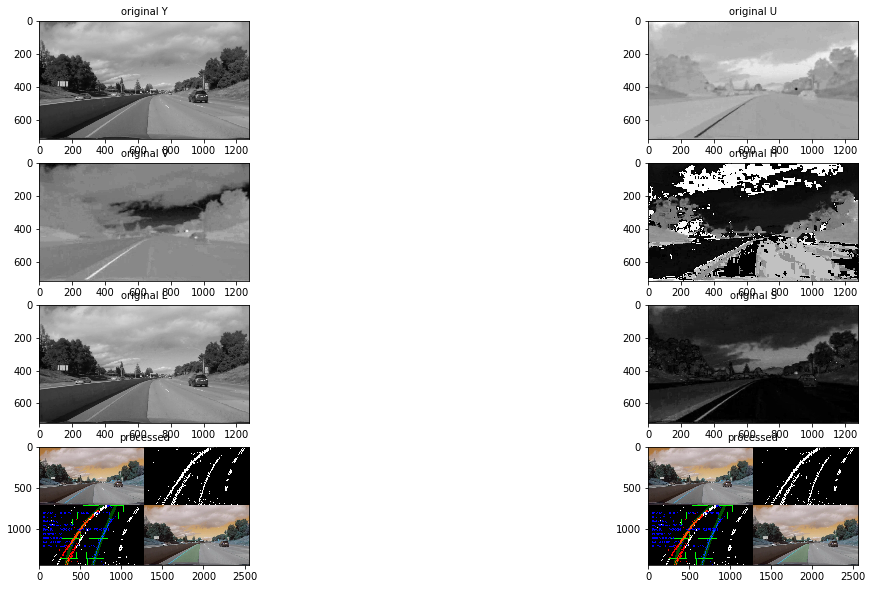

In [13]:
%matplotlib inline

left_line = Line()
right_line = Line()

# deprecated
left_fit = None
right_fit = None

image_displays=[]

image = cv2.imread("test_images/test_challenge_1.jpg")
#plt.imshow(process_image(image))'
#plt.imshow(process_image(image))

#undistd = undist(image)
#persp = perspective_transform(undistd)
#gradx = abs_sobel_thresh(Y(persp), orient='x', sobel_kernel=ksize, thresh=(50, 200)) # was 10,100#

#mag_L = mag_thresh(L(persp), thresh=(50, 200))
#mag_Y = mag_thresh(Y(persp), thresh=None)
#mag_U = mag_thresh(U(persp), thresh=(50, 200))
#mag_S = mag_thresh(S(persp), thresh=(50, 200))
    
#left_lane_line = np.zeros_like(gradx)
#thresholded_L = thresh(L(persp), thresh=(130, 255))
#thresholded_Y = thresh(Y(persp), thresh=(200, 255))
#thresholded_V = thresh(V(persp), thresh=(220, 255))
#thresholded_L = thresh(L(persp), thresh=(180, 255))


image_displays.append(ImageDisplay(Y(undist(image)), "original Y", "gray"))
image_displays.append(ImageDisplay(U(undist(image)), "original U", "gray"))
image_displays.append(ImageDisplay(V(undist(image)), "original V", "gray"))
image_displays.append(ImageDisplay(H(undist(image)), "original H", "gray"))
image_displays.append(ImageDisplay(L(undist(image)), "original L", "gray"))
image_displays.append(ImageDisplay(S(undist(image)), "original S", "gray"))

image_displays.append(ImageDisplay(process_image_video1(image), "processed", "gray"))
image_displays.append(ImageDisplay(process_image_video1(image), "processed", "gray"))
#image_displays.append(ImageDisplay(process_image(image), "processed_again", "gray"))

# display all images
show_multiple(image_displays)



#image = cv2.imread("test_images/straight_lines2.jpg")

# Choose a Sobel kernel size
#ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
#gradx = abs_sobel_thresh(S(image), orient='x', sobel_kernel=ksize, thresh=(10, 100))
#grady = abs_sobel_thresh(S(image), orient='y', sobel_kernel=ksize, thresh=(10, 100))
#mag_binary = mag_thresh(S(image), sobel_kernel=ksize, mag_thresh=(10, 100))
#dir_binary = dir_threshold(L(image), sobel_kernel=ksize, thresh=(0.1, 0.3))

#histogram = np.sum(gradx[int(gradx.shape[0]/2):,:], axis=0)
#plt.plot(histogram)

#return sliding_window(gradx)

#combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[(gradx == 1) & (grady == 1)] = 1


In [15]:
%matplotlib inline

left_line = Line()
right_line = Line()

video = "project_video"
#video = "challenge_video"
#video = "harder_challenge_video"

mode = ""
#mode = "with_pipeline_1"

white_output = video + "_" + mode + "_out.mp4"
clip1 = VideoFileClip(video + ".mp4")

# choose pipeline
white_clip = clip1.fl_image(process_image_video1)
#white_clip = clip1.fl_image(process_image_video2)
#white_clip = clip1.fl_image(process_image)
#white_clip = clip1.fl_image(process_image_find_cspace)

%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_with_challenge_pipeline_out.mp4
[MoviePy] Writing video project_video_with_challenge_pipeline_out.mp4



100%|█████████▉| 1260/1261 [06:50<00:00,  2.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_challenge_pipeline_out.mp4 

CPU times: user 5min 17s, sys: 16.3 s, total: 5min 34s
Wall time: 6min 56s


In [ ]:

    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    #fig = plt.figure(figsize=(17.778, 10))  # a new figure window
    #ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
    #ax.plot(left_fitx, ploty, color='yellow')
    #ax.plot(right_fitx, ploty, color='yellow')
    #ax.set_xlim([0, 1280])
    #ax.set_ylim([720, 0])
    #canvas = FigureCanvas(fig)
    #canvas.draw()       # draw the canvas, cache the renderer
    #image = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    #image  = image.reshape(canvas.get_width_height()[::-1] + (3,))
    #result = cv2.addWeighted(result, 1, image, 0.3, 0)
    
    #plt.imshow(image)
    
    #print(image.shape)